In [28]:
from sknetwork.clustering import Louvain, modularity, PropagationClustering, KMeans
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from IPython.display import SVG
from sknetwork.embedding import GSVD
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from infomap import Infomap
import numpy as np
import itertools
import matplotlib as mpl
import pandas as pd
import time

### Infomap

In [29]:
def Create_Dictionary(G):
    #Diccionarios para recordar nombres
    dicId={}
    dicUbigeo={}
    n=0
    for i in G.nodes():
        dicId[n]=i
        dicUbigeo[i]=n
        n=n+1
    return dicId, dicUbigeo

In [30]:
def Draw_Groups(G,minLabels):
    cant_ele={}
    val_map={}
    no_graph=[]

    for i in range(len(minLabels)):
        #val_map[dicId[i]]=int(minLabels[i])
        if (not(minLabels[i] in cant_ele.keys())):
            cant_ele[minLabels[i]]=0
        cant_ele[minLabels[i]]+=1

    for i in cant_ele:
        if(cant_ele[i]>G.number_of_nodes()/2):
            no_graph.append(i)
            
    for i in range(len(minLabels)):
        if not(minLabels[i] in no_graph):
            val_map[dicId[i]]=int(minLabels[i])
        
    if(len(val_map)):
        G_subgroup = G.subgraph(val_map.keys())
        low, *_, high = sorted(val_map.values())
        norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
        mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
        values=[mapper.to_rgba(i) for i in val_map.values()]

        plt.figure(3,figsize=(15,15)) 
        nx.draw_circular(G_subgroup, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='black',
                        font_size=10,node_size=1000)
        plt.show()
    else:
        print("No se generaron grupos válidos")
        
    return val_map

In [31]:
def Infomap_function(G, bipartite_teleportation, weight_threshold, two_level, teleportation_probability,
                     num_trials, core_loop_limit):
    
    im = Infomap()
    for e in G.edges.data("weight", default=1):
        im.addLink(dicUbigeo[e[0]],dicUbigeo[e[1]],e[2])

    # Run the Infomap search algorithm to find optimal modules
    im.run(bipartite_teleportation = bipartite_teleportation, weight_threshold = weight_threshold, 
           teleportation_probability = teleportation_probability, num_trials=num_trials,
           core_loop_limit =core_loop_limit,
           two_level=two_level, flow_model = 'directed')

    #print("Cantidad de grupos:",im.num_top_modules)
    np.zeros((2,3,4),dtype=np.int16)

    labels=np.zeros(G.number_of_nodes(),dtype=np.int16)

    for node in im.tree:
        if node.is_leaf:
            labels[node.node_id]=int(node.module_id)

    val_map = Draw_Groups(grafo,labels)
    

### Parámetros

In [32]:
bipartite_teleportation = [False]
weight_threshold = [150]
two_level = [False]
teleportation_probability = [0.75] 
num_trials = [9]
core_loop_limit = [10]

options = [bipartite_teleportation, weight_threshold,two_level, teleportation_probability, num_trials, core_loop_limit]
params = list(itertools.product(*options))

### Departamentos

In [33]:
uGraph="Input/grafoPeruDepartamentos.net"
uMapLevel="Input/departamentos/DEPARTAMENTOS.shp"
level="dep"

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dicId, dicUbigeo = Create_Dictionary(grafo)

param = params[0]
Infomap_function(grafo, *param)   

No se generaron grupos válidos


### Provincias

In [34]:
uGraph="Input/grafoPeruProvincias.net"
uMapLevel="Input/provincias/PROVINCIAS.shp"
level="pro"

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dicId, dicUbigeo = Create_Dictionary(grafo)

param = params[0]
Infomap_function(grafo, *param)   

No se generaron grupos válidos


### Distritos

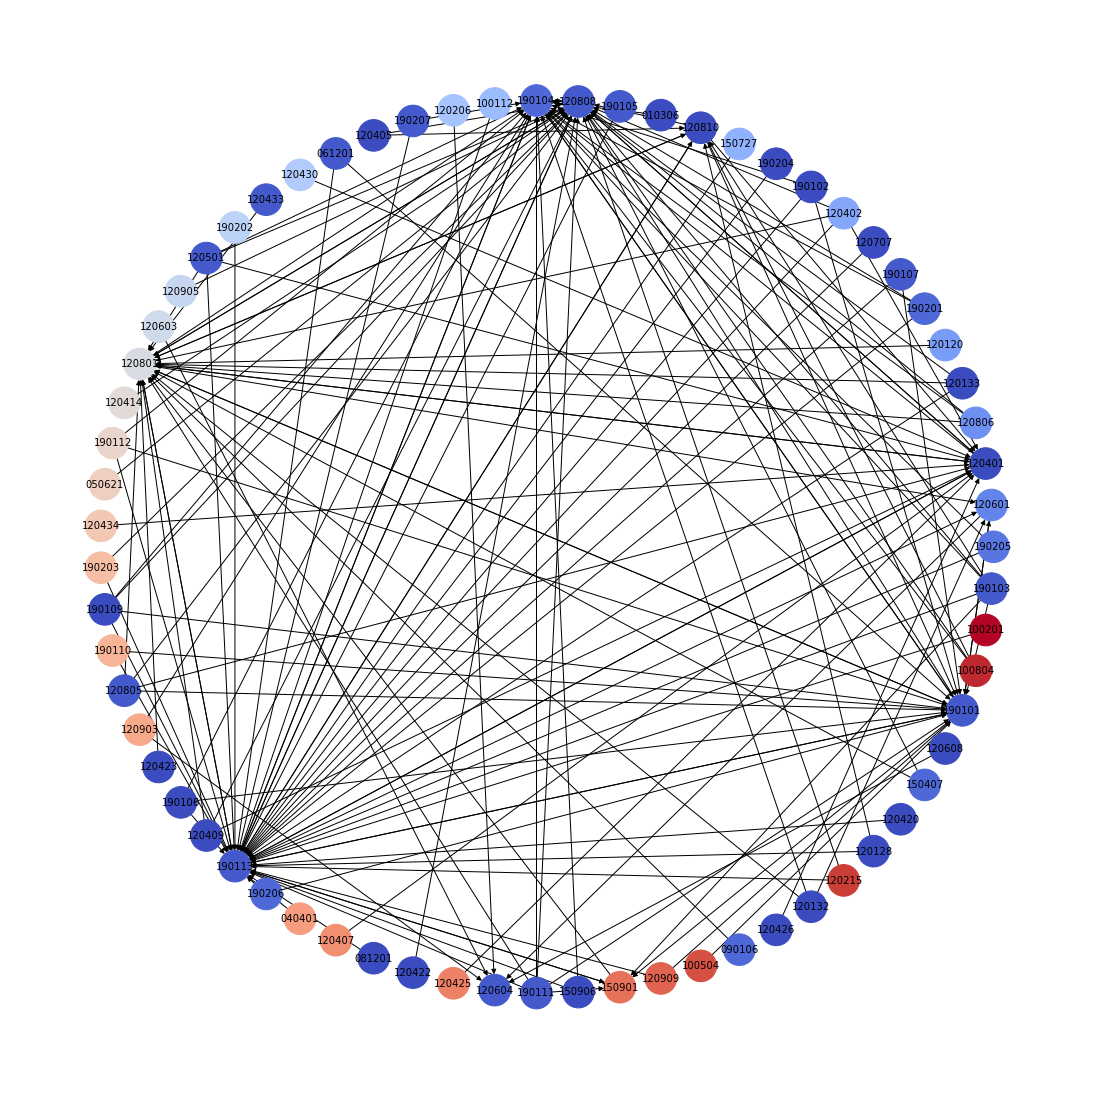

In [35]:
uGraph="Input/grafoPeruDistritos.net"
uMapLevel="Input/distritos/DISTRITOS.shp"
level="dis"
modularity_function='dugue'

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dicId, dicUbigeo = Create_Dictionary(grafo)

param = params[0]
Infomap_function(grafo, *param)  